In [ ]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
from sklearn.feature_selection import RFE
from pandas import DataFrame
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
'''
Loading Gensim and nltk libraries
'''

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(400)
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/RT/final_df.pkl', 'rb') as f:
  df = pickle.load(f)

In [ ]:
df.head(2)

,title,date
0,Kenya To Make Electricity Available For 100 Pe...,2017-01-02
1,An Open Letter To The U.S. Energy Secretary No...,2017-01-02


In [ ]:
df = df.reset_index()

In [ ]:
df.columns=['PrimaryKey','title','date']

In [ ]:
df.shape

(17062, 3)

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
example = df['title'][10]
example

'Analyst: Istanbul Attack Precursor To ISIS Strike On Saudi Oil'

In [ ]:
#Run for Roberta Model
encoded_text = tokenizer(example, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [ ]:
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.4098328, 'roberta_neu': 0.58126104, 'roberta_pos': 0.008906119}


In [ ]:
def ploarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors = 'pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [ ]:
res ={}
for i, row in tqdm(df.iterrows(),total = len(df)):
  try:
    text = row['title']
    myid = row['PrimaryKey']
    roberta_result= ploarity_scores_roberta(text)

    both = {**roberta_result}
    res[myid] = both
  except RuntimeError:
    print(f'Broke of id {myid}')

100%|██████████| 17062/17062 [28:38<00:00,  9.93it/s]


In [ ]:
results_df = pd.DataFrame(res).T

In [ ]:
results_df = results_df.reset_index().rename(columns = {'index': 'PrimaryKey'})

In [ ]:
results_df = results_df.merge(df,how = 'left')

In [ ]:
results_df.head()

,PrimaryKey,roberta_neg,roberta_neu,roberta_pos,title,date
0,0,0.044472,0.855430,0.100098,Kenya To Make Electricity Available For 100 Pe...,2017-01-02
1,1,0.028048,0.921188,0.050764,An Open Letter To The U.S. Energy Secretary No...,2017-01-02
2,2,0.087620,0.877029,0.035351,The South American Nation Seeing An Oil And Go...,2017-01-02
3,3,0.036261,0.930539,0.033200,"Iran Picks 29 Foreign Companies To Bid In Oil,...",2017-01-03
4,4,0.889520,0.107211,0.003268,"36 Killed In IS Attack In Baghdad, More Attack...",2017-01-03


In [ ]:
with open('/content/drive/My Drive/RT/pos_neg_scores.pkl', 'wb') as f:
    pickle.dump(results_df, f)


####Polarity: Polarity measures the sentiment of the text, typically on a scale from -1 (most negative) to +1 (most positive). It can be calculated as:


Polarity= (Positive Score−Negative Score)/(Positive Score+Negative Score
+Neutral Score)

​


####Subjectivity: Subjectivity measures the degree to which a text expresses opinions or feelings, rather than being factual. It can be calculated as:

Subjectivity= (Positive Score+Negative Score)/(Positive Score+Negative Score+Neutral Score)
​


In [ ]:
with open('/content/drive/My Drive/RT/pos_neg_scores.pkl', 'rb') as f:
  results_df = pickle.load(f)

In [ ]:
results_df.head(2)

,PrimaryKey,roberta_neg,roberta_neu,roberta_pos,title,date
0,0,0.044472,0.855430,0.100098,Kenya To Make Electricity Available For 100 Pe...,2017-01-02
1,1,0.028048,0.921188,0.050764,An Open Letter To The U.S. Energy Secretary No...,2017-01-02


In [ ]:
results_df.shape

(17062, 6)

In [ ]:
# prompt: add tw ocoln in results_Df as
# Polarity= (Positive Score−Negative Score)/(Positive Score+Negative Score
# +Neutral Score)
# Subjectivity= (Positive Score+Negative Score)/(Positive Score+Negative Score+Neutral Score)

results_df['Polarity'] = (results_df['roberta_pos'] - results_df['roberta_neg']) / (results_df['roberta_pos'] + results_df['roberta_neg'] + results_df['roberta_neu'])
results_df['Subjectivity'] = (results_df['roberta_pos'] + results_df['roberta_neg']) / (results_df['roberta_pos'] + results_df['roberta_neg'] + results_df['roberta_neu'])

In [ ]:
results_df.head()

,PrimaryKey,roberta_neg,roberta_neu,roberta_pos,title,date,Polarity,Subjectivity
0,0,0.044472,0.855430,0.100098,Kenya To Make Electricity Available For 100 Pe...,2017-01-02,0.055626,0.144570
1,1,0.028048,0.921188,0.050764,An Open Letter To The U.S. Energy Secretary No...,2017-01-02,0.022716,0.078812
2,2,0.087620,0.877029,0.035351,The South American Nation Seeing An Oil And Go...,2017-01-02,-0.052269,0.122971
3,3,0.036261,0.930539,0.033200,"Iran Picks 29 Foreign Companies To Bid In Oil,...",2017-01-03,-0.003061,0.069461
4,4,0.889520,0.107211,0.003268,"36 Killed In IS Attack In Baghdad, More Attack...",2017-01-03,-0.886252,0.892789


In [ ]:
with open('/content/drive/My Drive/RT/sentiments_df.pkl', 'wb') as f:
  pickle.dump(results_df, f)


In [ ]:
# prompt: read sentiments_df from drive

with open('/content/drive/My Drive/RT/sentiments_df.pkl', 'rb') as f:
  sentiments_df = pickle.load(f)


In [ ]:
sentiments_df.head()

,PrimaryKey,roberta_neg,roberta_neu,roberta_pos,title,date,Polarity,Subjectivity
0,0,0.044472,0.855430,0.100098,Kenya To Make Electricity Available For 100 Pe...,2017-01-02,0.055626,0.144570
1,1,0.028048,0.921188,0.050764,An Open Letter To The U.S. Energy Secretary No...,2017-01-02,0.022716,0.078812
2,2,0.087620,0.877029,0.035351,The South American Nation Seeing An Oil And Go...,2017-01-02,-0.052269,0.122971
3,3,0.036261,0.930539,0.033200,"Iran Picks 29 Foreign Companies To Bid In Oil,...",2017-01-03,-0.003061,0.069461
4,4,0.889520,0.107211,0.003268,"36 Killed In IS Attack In Baghdad, More Attack...",2017-01-03,-0.886252,0.892789


In [ ]:
sentiments_df.shape

(17062, 8)

In [ ]:
# polarity_less_than_minus_77 = sentiments_df[sentiments_df['Subjectivity'] < 0.3]
# for row in polarity_less_than_minus_77.itertuples():
#   print(f"Title: {row.title}")
#   print(f"Subjectivity: {row.Subjectivity}")
#   print("-------------------------------------------------------------------")


In [ ]:
sentiments_df.tail()

,PrimaryKey,roberta_neg,roberta_neu,roberta_pos,title,date,Polarity,Subjectivity
17057,17057,0.319596,0.657002,0.023401,Russia Halves Gasoline Shipments via Railway A...,2024-04-04,-0.296195,0.342998
17058,17058,0.457307,0.486183,0.056509,Renewable Energy Investment Not Enough to Reac...,2024-04-04,-0.400798,0.513817
17059,17059,0.009735,0.632124,0.358141,Tesla Sends Scouts Across India to Find Ideal ...,2024-04-04,0.348406,0.367875
17060,17060,0.019148,0.938710,0.042143,Trans Mountain’s Expanded Oil Pipeline to Star...,2024-04-04,0.022995,0.061290
17061,17061,0.100260,0.745708,0.154032,The 57 Companies Most Responsible for Global C...,2024-04-04,0.053772,0.254292


# Latent Dirichlet Allocation #

This notebook is a part of my learning journey which I've been documenting from Udacity's Natural Language Processing Nanodegree program, which helped me a lot to learn and excel advanced data science stuff such as PySpark. Thank you so much Udacity for providing such quality content.

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

* Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
* LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial.
* It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

In [ ]:
data = pd.read_pickle('/content/drive/My Drive/RT/final_df.pkl')
data.head()

,title,date
0,Kenya To Make Electricity Available For 100 Pe...,2017-01-02
1,An Open Letter To The U.S. Energy Secretary No...,2017-01-02
2,The South American Nation Seeing An Oil And Go...,2017-01-02
3,"Iran Picks 29 Foreign Companies To Bid In Oil,...",2017-01-03
4,"36 Killed In IS Attack In Baghdad, More Attack...",2017-01-03


In [ ]:
data_text = data[:][['title']]
data_text['index'] = data_text.index
documents = data_text

Let's glance at the dataset:

In [ ]:
'''
Get the total number of documents
'''
print(len(documents))

17062


In [ ]:
documents.head()

,title,index
0,Kenya To Make Electricity Available For 100 Pe...,0
1,An Open Letter To The U.S. Energy Secretary No...,1
2,The South American Nation Seeing An Oil And Go...,2
3,"Iran Picks 29 Foreign Companies To Bid In Oil,...",3
4,"36 Killed In IS Attack In Baghdad, More Attack...",4


## Data Preprocessing ##

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
'''
Preview a document after preprocessing
'''
document_num = 200
doc_sample = documents[documents['index'] == document_num].values[0][0]

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['CVR', 'Energy', 'Shareholders', 'Get', 'Windfall', 'from', 'Trump', 'Election']


Tokenized and lemmatized document: 
['energi', 'sharehold', 'windfal', 'trump', 'elect']


In [ ]:
print(documents.iloc[14]['title'])

Tata Power to offset losses due to higher coal prices


Let's now preprocess all the news headlines we have. To do that, let's use the [map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) function from pandas to apply `preprocess()` to the `headline_text` column


In [ ]:
data_text['title'] = data_text['title'].astype(str)

In [ ]:
# preprocess all the headlines, saving the list of results as 'processed_docs'
processed_docs = documents['title'].map(preprocess)
type(processed_docs)

pandas.core.series.Series

In [ ]:
'''
Preview 'processed_docs'
'''
processed_docs.head(20)

0                [kenya, electr, avail, percent, popul]
1             [open, letter, energi, secretari, nomine]
2        [south, american, nation, see, gold, breakout]
3                [iran, pick, foreign, compani, tender]
4                       [kill, attack, baghdad, attack]
5               [venezuela, start, product, opec, deal]
6                                                [slip]
7     [offshor, vessel, provid, see, clear, sign, im...
8                         [libya, close, daili, output]
9                         [energi, price, rise, commod]
10    [analyst, istanbul, attack, precursor, isi, st...
11                     [tancoal, sustain, record, sale]
12           [mechel, increas, export, elga, coalfield]
13                   [baralaba, coal, compani, appoint]
14     [tata, power, offset, loss, higher, coal, price]
15           [goldman, sach, see, complianc, opec, cut]
16    [atrum, coal, atlant, carbon, agre, term, expo...
17    [dismiss, tanesco, chief, affect, kibo, mi

In [ ]:
################### Jaccard Similarity #####################

In [ ]:
dirichlet_dict = corpora.Dictionary(processed_docs)

In [ ]:
dirichlet_dict.filter_extremes(no_below=15, no_above=0.07, keep_n=100000)

In [ ]:
bow_corpus = [dirichlet_dict.doc2bow(text) for text in processed_docs]

In [ ]:
# Considering 1-15 topics, as the last is cut off

num_topics = list(range(16)[1:])
num_keywords = 15
'''
LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha= 0.2,
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i,
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    print(i,'th loop completed')
'''

"\nLDA_models = {}\nLDA_topics = {}\nfor i in num_topics:\n    LDA_models[i] = LdaModel(corpus=bow_corpus,\n                             id2word=dirichlet_dict,\n                             num_topics=i,\n                             update_every=1,\n                             chunksize=len(bow_corpus),\n                             passes=20,\n                             alpha= 0.2,\n                             random_state=42)\n\n    shown_topics = LDA_models[i].show_topics(num_topics=i,\n                                             num_words=num_keywords,\n                                             formatted=False)\n    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]\n    print(i,'th loop completed')\n"

In [ ]:
LDA_models = pd.read_pickle('/content/drive/My Drive/RT/LDA_models_15.pkl')
LDA_topics = pd.read_pickle('/content/drive/My Drive/RT/LDA_topics_15.pkl')

In [ ]:
LDA_topics[6]

In [ ]:
# save results of the  LDA_models and LDA_topics as a pickle

import pickle

# Save the LDA models and topics as a pickle
with open('/content/drive/My Drive/RT/LDA_models_15.pkl', 'wb') as f:
    pickle.dump(LDA_models, f)

with open('/content/drive/My Drive/RT/LDA_topics_15.pkl', 'wb') as f:
    pickle.dump(LDA_topics, f)


"\nimport pickle\n\n# Save the LDA models and topics as a pickle\nwith open('/content/drive/My Drive/RT SEM2/Coal/LDA_models_15.pkl', 'wb') as f:\n    pickle.dump(LDA_models, f)\n\nwith open('/content/drive/My Drive/RT SEM2/Coal/LDA_topics_15.pkl', 'wb') as f:\n    pickle.dump(LDA_topics, f)\n"

In [ ]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))

    return float(len(intersection))/float(len(union))

In [ ]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))

        jaccard_sims.append(sims)

    LDA_stability[num_topics[i]] = jaccard_sims

mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [ ]:
mean_stabilities

[0.41025641025641024,
 0.28028805391888556,
 0.18279407961803606,
 0.17446801109249294,
 0.13616027312781875,
 0.13273594878564451,
 0.11324889151062723,
 0.09853574394427032,
 0.08372531273718063,
 0.061540088589284926,
 0.06118357667710084,
 0.059027181198100374,
 0.05663135962295592,
 0.053031065224632315]

In [ ]:
coherences = [CoherenceModel(model=LDA_models[i], texts=processed_docs, dictionary=dirichlet_dict, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [ ]:
coherences

[0.17644082512944742,
 0.2824131472877275,
 0.25220252653513836,
 0.2656534132854898,
 0.2875966685046833,
 0.2957426575335393,
 0.28712352775827893,
 0.28061817821761825,
 0.26062564633219387,
 0.2767990587795083,
 0.2917811909972816,
 0.2957503771425299,
 0.3108617348876794,
 0.3152812572301408]

In [ ]:
coherences

[0.17644082512944742,
 0.2824131472877275,
 0.25220252653513836,
 0.2656534132854898,
 0.2875966685046833,
 0.2957426575335393,
 0.28712352775827893,
 0.28061817821761825,
 0.26062564633219387,
 0.2767990587795083,
 0.2917811909972816,
 0.2957503771425299,
 0.3108617348876794,
 0.3152812572301408]

In [ ]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

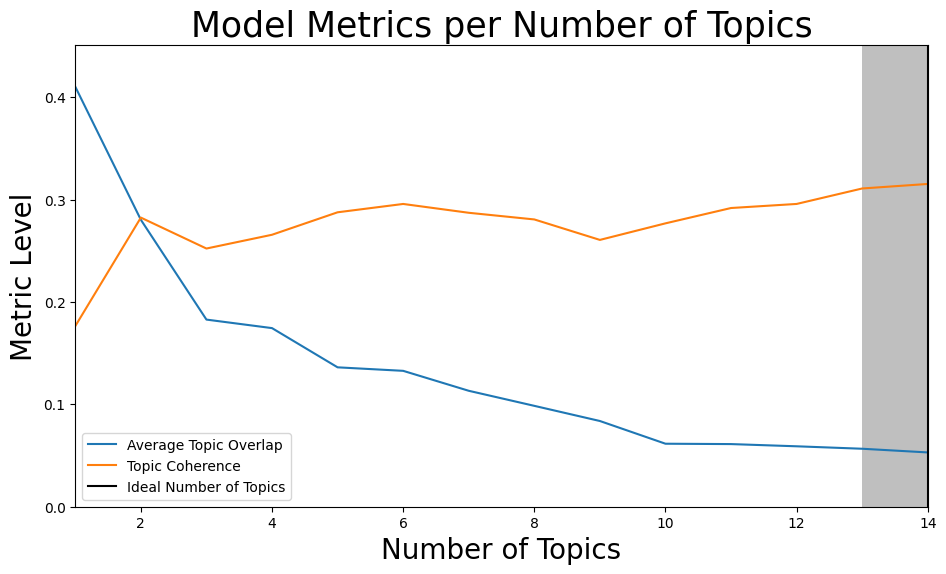

In [ ]:
plt.figure(figsize=(11,6))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])

ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=10)
plt.show()

## Bag of words on the dataset

Now let's create a dictionary from 'processed_docs' containing the number of times a word appears in the training set. To do that, let's pass `processed_docs` to [`gensim.corpora.Dictionary()`](https://radimrehurek.com/gensim/corpora/dictionary.html) and call it '`dictionary`'.

In [ ]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [ ]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 avail
1 electr
2 kenya
3 percent
4 popul
5 energi
6 letter
7 nomine
8 open
9 secretari
10 american


In [ ]:
print(list(dictionary.items())[200])


(200, 'releas')


** Gensim filter_extremes **
​
[`filter_extremes(no_below=5, no_above=0.5, keep_n=100000)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes)
​
Filter out tokens that appear in
​
* less than no_below documents (absolute number) or
* more than no_above documents (fraction of total corpus size, not absolute number).
* after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

In [ ]:
'''
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=15, no_above=0.07, keep_n=100000)

In [ ]:
# prompt: show top 10 most frequent words in dictionary

# Get the top 10 most frequent words in the dictionary
top_10_words = dictionary.most_common(10)

# Print the top 10 most frequent words and their counts
for word, count in top_10_words:
    print(f"Word: {word}, Count: {count}")

Word: energi, Count: 1176
Word: china, Count: 1063
Word: product, Count: 915
Word: crude, Count: 838
Word: russia, Count: 778
Word: power, Count: 711
Word: export, Count: 708
Word: project, Count: 606
Word: opec, Count: 581
Word: india, Count: 541


** Gensim doc2bow **

[`doc2bow(document)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow)

* Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
bow_corpus

In [ ]:
processed_docs[200]

['energi', 'sharehold', 'windfal', 'trump', 'elect']

In [ ]:
'''
Checking Bag of Words corpus for our sample document --> (token_id, token_count)
'''
bow_corpus[document_num]

[(3, 1), (150, 1), (445, 1), (446, 1), (447, 1)]

In [ ]:
'''
Preview BOW for our sample preprocessed document
'''
# Here document_num is document number 4310 which we have checked in Step 2
bow_doc_4310 = bow_corpus[document_num]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0],
                                                     dictionary[bow_doc_4310[i][0]],
                                                     bow_doc_4310[i][1]))

Word 3 ("energi") appears 1 time.
Word 150 ("trump") appears 1 time.
Word 445 ("elect") appears 1 time.
Word 446 ("sharehold") appears 1 time.
Word 447 ("windfal") appears 1 time.


## Running LDA using Bag of Words ##

We are going for 10 topics in the document corpus.

** We will be running LDA using all CPU cores to parallelize and speed up model training.**

Some of the parameters we will be tweaking are:

* **num_topics** is the number of requested latent topics to be extracted from the training corpus.
* **id2word** is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing.
* **workers** is the number of extra processes to use for parallelization. Uses all available cores by default.
* **alpha** and **eta** are hyperparameters that affect sparsity of the document-topic (theta) and topic-word (lambda) distributions. We will let these be the default values for now(default value is `1/num_topics`)
    - Alpha is the per document topic distribution.
        * High alpha: Every document has a mixture of all topics(documents appear similar to each other).
        * Low alpha: Every document has a mixture of very few topics

    - Eta is the per topic word distribution.
        * High eta: Each topic has a mixture of most words(topics appear similar to each other).
        * Low eta: Each topic has a mixture of few words.

* ** passes ** is the number of training passes through the corpus. For  example, if the training corpus has 50,000 documents, chunksize is  10,000, passes is 2, then online training is done in 10 updates:
    * `#1 documents 0-9,999 `
    * `#2 documents 10,000-19,999 `
    * `#3 documents 20,000-29,999 `
    * `#4 documents 30,000-39,999 `
    * `#5 documents 40,000-49,999 `
    * `#6 documents 0-9,999 `
    * `#7 documents 10,000-19,999 `
    * `#8 documents 20,000-29,999 `
    * `#9 documents 30,000-39,999 `
    * `#10 documents 40,000-49,999`

In [ ]:
# LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine

lda_model = gensim.models.LdaModel(bow_corpus,
                                    num_topics = 6,
                                    id2word = dictionary,
                                    passes = 20,
                                    alpha = 0.2)

# LDA multicore
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
'''
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=5,
                                       id2word = dictionary,
                                       passes = 2,
                                       workers=2)
'''

'\nlda_model = gensim.models.LdaMulticore(bow_corpus,\n                                       num_topics=5,\n                                       id2word = dictionary,\n                                       passes = 2,\n                                       workers=2)\n'

In [ ]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(topic, idx ))
    print("\n")

Topic: 0.040*"billion" + 0.036*"product" + 0.023*"energi" + 0.020*"invest" + 0.019*"saudi" + 0.017*"profit" + 0.017*"deal" + 0.016*"boost" + 0.016*"firm" + 0.012*"plan" 
Words: 0


Topic: 0.047*"power" + 0.031*"mine" + 0.029*"plant" + 0.023*"project" + 0.019*"emiss" + 0.018*"energi" + 0.017*"miner" + 0.014*"gold" + 0.012*"plan" + 0.012*"mexico" 
Words: 1


Topic: 0.036*"energi" + 0.026*"china" + 0.025*"climat" + 0.023*"demand" + 0.020*"south" + 0.018*"renew" + 0.018*"global" + 0.015*"metal" + 0.015*"power" + 0.015*"copper" 
Words: 2


Topic: 0.047*"opec" + 0.030*"cut" + 0.025*"pipelin" + 0.023*"million" + 0.019*"germani" + 0.016*"carbon" + 0.016*"output" + 0.015*"russia" + 0.015*"refineri" + 0.015*"attack" 
Words: 3


Topic: 0.043*"market" + 0.029*"sanction" + 0.021*"fuel" + 0.020*"suppli" + 0.016*"american" + 0.015*"iran" + 0.014*"venezuela" + 0.014*"tesla" + 0.014*"energi" + 0.013*"lithium" 
Words: 4


Topic: 0.043*"crude" + 0.034*"export" + 0.034*"russian" + 0.031*"import" + 0.031*"

## Performance evaluation by classifying sample document using LDA Bag of Words model##

We will check to see where our test document would be classified.

In [ ]:
'''
Text of sample document 4310
'''
processed_docs[200]

['energi', 'sharehold', 'windfal', 'trump', 'elect']

In [ ]:
'''
Check which topic our test document belongs to using the LDA Bag of Words model.
'''
document_num = 200

# Our test document is document number 4310
for index, score in sorted(lda_model[bow_corpus[document_num]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6000478863716125	 
Topic: 0.036*"china" + 0.033*"crude" + 0.031*"demand" + 0.025*"year" + 0.024*"rise" + 0.021*"report" + 0.020*"market" + 0.019*"global" + 0.016*"gasolin" + 0.014*"fall"

Score: 0.2703307569026947	 
Topic: 0.062*"power" + 0.029*"plant" + 0.029*"project" + 0.028*"energi" + 0.022*"miner" + 0.020*"gold" + 0.016*"resourc" + 0.015*"copper" + 0.014*"fuel" + 0.013*"say"

Score: 0.03283587843179703	 
Topic: 0.045*"energi" + 0.041*"billion" + 0.022*"deal" + 0.020*"plan" + 0.018*"invest" + 0.014*"giant" + 0.014*"project" + 0.014*"firm" + 0.013*"exxon" + 0.012*"mexico"

Score: 0.03226573020219803	 
Topic: 0.052*"india" + 0.049*"russian" + 0.027*"china" + 0.025*"import" + 0.019*"venezuela" + 0.018*"sanction" + 0.018*"refin" + 0.015*"tanker" + 0.015*"renew" + 0.015*"crude"

Score: 0.03225989639759064	 
Topic: 0.037*"record" + 0.031*"climat" + 0.023*"world" + 0.021*"china" + 0.019*"europ" + 0.019*"germani" + 0.019*"mine" + 0.019*"high" + 0.018*"biden" + 0.017*"largest"

Sc

## Testing model on unseen document ##

In [ ]:
unseen_document = "India likely to witness slower growth in steel consumption in FY25: Icra"

# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.3548584282398224	 Topic: 0.052*"india" + 0.049*"russian" + 0.027*"china" + 0.025*"import" + 0.019*"venezuela"
Score: 0.35483071208000183	 Topic: 0.036*"china" + 0.033*"crude" + 0.031*"demand" + 0.025*"year" + 0.024*"rise"
Score: 0.19352982938289642	 Topic: 0.045*"energi" + 0.041*"billion" + 0.022*"deal" + 0.020*"plan" + 0.018*"invest"
Score: 0.03226035088300705	 Topic: 0.037*"record" + 0.031*"climat" + 0.023*"world" + 0.021*"china" + 0.019*"europ"
Score: 0.032260339707136154	 Topic: 0.062*"russia" + 0.055*"product" + 0.043*"export" + 0.040*"opec" + 0.027*"saudi"
Score: 0.032260335981845856	 Topic: 0.062*"power" + 0.029*"plant" + 0.029*"project" + 0.028*"energi" + 0.022*"miner"


The model correctly classifies the unseen document with '42'% probability to the X category.

In [ ]:
# Create a new dataframe
df_lda = pd.DataFrame(columns=['Original Title', 'Doc2Bow Title', 'Topic 1 Score', 'Topic 2 Score', 'Topic 3 Score', 'Topic 4 Score', 'Topic 5 Score', 'Topic 6 Score'])

# Iterate through the data
for index, row in data.iterrows():
    # Get the original title
    original_title = row['title']

    # Preprocess the title and convert it to a bag-of-words representation
    doc_bow = dictionary.doc2bow(preprocess(original_title))

    # Get the scores for each topic
    topic_scores = lda_model[doc_bow]

    # Create a new row in the dataframe
    df_lda.loc[index] = [original_title, doc_bow, topic_scores[0][1], topic_scores[1][1], topic_scores[2][1], topic_scores[3][1], topic_scores[4][1], topic_scores[5][1]]

# Print the dataframe
df_lda.head()


,Original Title,Doc2Bow Title,Topic 1 Score,Topic 2 Score,Topic 3 Score,Topic 4 Score,Topic 5 Score,Topic 6 Score
0,Kenya To Make Electricity Available For 100 Pe...,"[(0, 1), (1, 1), (2, 1)]",0.048360,0.285550,0.285669,0.047636,0.285150,0.047636
1,An Open Letter To The U.S. Energy Secretary No...,"[(3, 1), (4, 1), (5, 1)]",0.047806,0.047622,0.047622,0.048396,0.048962,0.759593
2,The South American Nation Seeing An Oil And Go...,"[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]",0.193523,0.033633,0.032380,0.032259,0.514657,0.193547
3,"Iran Picks 29 Foreign Companies To Bid In Oil,...","[(11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]",0.032262,0.439918,0.032987,0.032881,0.428752,0.033200
4,"36 Killed In IS Attack In Baghdad, More Attack...","[(16, 2), (17, 1)]",0.285686,0.523369,0.047621,0.047621,0.048082,0.047621


In [ ]:
topic_scores = lda_model[doc_bow]
topic_scores

[(0, 0.5482124),
 (1, 0.03245091),
 (2, 0.032981556),
 (3, 0.032792367),
 (4, 0.0326003),
 (5, 0.32096246)]

In [ ]:
df_lda['Highest Topic'] = df_lda[['Topic 1 Score', 'Topic 2 Score', 'Topic 3 Score', 'Topic 4 Score', 'Topic 5 Score',
                                  'Topic 6 Score']].idxmax(axis=1)
df_lda.head(20)


,Original Title,Doc2Bow Title,Topic 1 Score,Topic 2 Score,Topic 3 Score,Topic 4 Score,Topic 5 Score,Topic 6 Score,Highest Topic
0,Kenya To Make Electricity Available For 100 Pe...,"[(0, 1), (1, 1), (2, 1)]",0.048360,0.285550,0.285669,0.047636,0.285150,0.047636,Topic 3 Score
1,An Open Letter To The U.S. Energy Secretary No...,"[(3, 1), (4, 1), (5, 1)]",0.047806,0.047622,0.047622,0.048396,0.048962,0.759593,Topic 6 Score
2,The South American Nation Seeing An Oil And Go...,"[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]",0.193523,0.033633,0.032380,0.032259,0.514657,0.193547,Topic 5 Score
3,"Iran Picks 29 Foreign Companies To Bid In Oil,...","[(11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]",0.032262,0.439918,0.032987,0.032881,0.428752,0.033200,Topic 2 Score
4,"36 Killed In IS Attack In Baghdad, More Attack...","[(16, 2), (17, 1)]",0.285686,0.523369,0.047621,0.047621,0.048082,0.047621,Topic 2 Score
5,"Venezuela Starts 95,000 Bpd Production Cut As ...","[(18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]",0.032279,0.663185,0.032407,0.032835,0.206965,0.032330,Topic 2 Score
6,"TSX slips, Dec. 27–30","[(23, 1)]",0.545431,0.090914,0.090914,0.090914,0.090914,0.090914,Topic 1 Score
7,Offshore Vessels Provider Sees ‘Clear Signs’ O...,"[(9, 1), (24, 1), (25, 1), (26, 1), (27, 1), (...",0.213380,0.156201,0.021742,0.456517,0.021742,0.130419,Topic 4 Score
8,"Libya Close To 700,000 Bpd In Daily Oil Output","[(31, 1), (32, 1), (33, 1)]",0.047789,0.761195,0.048040,0.047737,0.047620,0.047620,Topic 2 Score
9,Energy Prices Rise More Than Other Commodities...,"[(3, 1), (34, 1), (35, 1)]",0.758398,0.047620,0.047620,0.049895,0.047620,0.048848,Topic 1 Score


In [ ]:
df_lda['Highest Topic'].value_counts()

Highest Topic
Topic 1 Score    3463
Topic 4 Score    3054
Topic 6 Score    3050
Topic 2 Score    2870
Topic 5 Score    2501
Topic 3 Score    2124
Name: count, dtype: int64

In [ ]:
sum_ = df_lda[['Topic 1 Score', 'Topic 2 Score', 'Topic 3 Score', 'Topic 4 Score', 'Topic 5 Score',
               'Topic 6 Score']].sum(axis=0)
sum_df = pd.DataFrame(sum_,columns = ['Sum'])
sum_df

,Sum
Topic 1 Score,3265.956055
Topic 2 Score,2909.037842
Topic 3 Score,2440.703857
Topic 4 Score,2941.810791
Topic 5 Score,2583.873291
Topic 6 Score,2920.618408


In [ ]:
sum_df['Proportion'] = sum_df['Sum'] * 100 / sum_df['Sum'].sum()
sum_df

,Sum,Proportion
Topic 1 Score,3265.956055,19.141695
Topic 2 Score,2909.037842,17.049805
Topic 3 Score,2440.703857,14.304911
Topic 4 Score,2941.810791,17.241888
Topic 5 Score,2583.873291,15.144024
Topic 6 Score,2920.618408,17.117680


In [ ]:
df_lda.to_pickle('/content/drive/My Drive/RT/df_lda_6_topics.pkl')

In [ ]:
with open('/content/drive/MyDrive/RT/df_lda_6_topics.pkl', 'rb') as f:
  df_lda = pickle.load(f)


In [ ]:
df_lda.to_csv('/content/drive/MyDrive/RT/df_lda_6_topics.csv')

In [ ]:
with open('/content/drive/MyDrive/RT/final_df.pkl', 'rb') as f:
  data = pickle.load(f)


In [ ]:
data.head(2)

,title,date
0,Kenya To Make Electricity Available For 100 Pe...,2017-01-02
1,An Open Letter To The U.S. Energy Secretary No...,2017-01-02


In [ ]:
df_lda.head()

,Original Title,Doc2Bow Title,Topic 1 Score,Topic 2 Score,Topic 3 Score,Topic 4 Score,Topic 5 Score,Topic 6 Score,Highest Topic
0,Kenya To Make Electricity Available For 100 Pe...,"[(0, 1), (1, 1), (2, 1)]",0.048360,0.285550,0.285669,0.047636,0.285150,0.047636,Topic 3 Score
1,An Open Letter To The U.S. Energy Secretary No...,"[(3, 1), (4, 1), (5, 1)]",0.047806,0.047622,0.047622,0.048396,0.048962,0.759593,Topic 6 Score
2,The South American Nation Seeing An Oil And Go...,"[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]",0.193523,0.033633,0.032380,0.032259,0.514657,0.193547,Topic 5 Score
3,"Iran Picks 29 Foreign Companies To Bid In Oil,...","[(11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]",0.032262,0.439918,0.032987,0.032881,0.428752,0.033200,Topic 2 Score
4,"36 Killed In IS Attack In Baghdad, More Attack...","[(16, 2), (17, 1)]",0.285686,0.523369,0.047621,0.047621,0.048082,0.047621,Topic 2 Score


In [ ]:
df_lda1= df_lda.copy()

In [ ]:
df_lda1 = df_lda1[['Original Title','Highest Topic']]

In [ ]:
df_lda1.head()

,Original Title,Highest Topic
0,Kenya To Make Electricity Available For 100 Pe...,Topic 3 Score
1,An Open Letter To The U.S. Energy Secretary No...,Topic 6 Score
2,The South American Nation Seeing An Oil And Go...,Topic 5 Score
3,"Iran Picks 29 Foreign Companies To Bid In Oil,...",Topic 2 Score
4,"36 Killed In IS Attack In Baghdad, More Attack...",Topic 2 Score


In [ ]:
df_lda1['Date'] = data['date']

In [ ]:
df_lda1.tail(2)

,Original Title,Highest Topic,Date
17060,Trans Mountain’s Expanded Oil Pipeline to Star...,Topic 6 Score,2024-04-04
17061,The 57 Companies Most Responsible for Global C...,Topic 1 Score,2024-04-04


In [ ]:
df_sent = pd.read_pickle('/content/drive/My Drive/RT/sentiments_df.pkl')
df_sent.tail(2)


,PrimaryKey,roberta_neg,roberta_neu,roberta_pos,title,date,Polarity,Subjectivity
17060,17060,0.019148,0.938710,0.042143,Trans Mountain’s Expanded Oil Pipeline to Star...,2024-04-04,0.022995,0.061290
17061,17061,0.100260,0.745708,0.154032,The 57 Companies Most Responsible for Global C...,2024-04-04,0.053772,0.254292


In [ ]:
df_sent.shape

(17062, 8)

In [ ]:
df_lda1[['Polarity','Subjectivity']] = df_sent[['Polarity','Subjectivity']]

In [ ]:
df_lda1.head(2)

,Original Title,Highest Topic,Date,Polarity,Subjectivity
0,Kenya To Make Electricity Available For 100 Pe...,Topic 3 Score,2017-01-02,0.055626,0.144570
1,An Open Letter To The U.S. Energy Secretary No...,Topic 6 Score,2017-01-02,0.022716,0.078812


In [ ]:
df_lda1['Highest Topic'].value_counts()

Highest Topic
Topic 1 Score    3463
Topic 4 Score    3054
Topic 6 Score    3050
Topic 2 Score    2870
Topic 5 Score    2501
Topic 3 Score    2124
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a new column called 'Scaled Polarity'
df_lda1['Scaled Polarity'] = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_lda1['Polarity'].values.reshape(-1, 1))

# Print the first five rows of the dataframe
df_lda1.head(2)


,Original Title,Highest Topic,Date,Polarity,Subjectivity,Scaled Polarity
0,Kenya To Make Electricity Available For 100 Pe...,Topic 3 Score,2017-01-02,0.055626,0.144570,0.524637
1,An Open Letter To The U.S. Energy Secretary No...,Topic 6 Score,2017-01-02,0.022716,0.078812,0.507556


In [ ]:
df_lda1[df_lda1['Subjectivity'] < 0.5].shape[0]

13604

In [ ]:
df_lda1['Date'] = pd.to_datetime(df_lda1['Date'])
df_lda1['Day'] = df_lda1['Date'].dt.day_name()
df_lda1.head(2)


,Original Title,Highest Topic,Date,Polarity,Subjectivity,Scaled Polarity,Day
0,Kenya To Make Electricity Available For 100 Pe...,Topic 3 Score,2017-01-02,0.055626,0.144570,0.524637,Monday
1,An Open Letter To The U.S. Energy Secretary No...,Topic 6 Score,2017-01-02,0.022716,0.078812,0.507556,Monday


In [ ]:
def change_weekend(df):
  for i in range(len(df)):
    if df.loc[i,'Day'] == 'Saturday':
      df.loc[i,'Date'] = df.loc[i,'Date'] - pd.Timedelta(days=1)
      df.loc[i,'Day'] = 'Friday'
    elif df.loc[i,'Day'] == 'Sunday':
      df.loc[i,'Date'] = df.loc[i,'Date'] + pd.Timedelta(days=1)
      df.loc[i,'Day'] = 'Monday'
  return df

df_lda1 = change_weekend(df_lda1)


In [ ]:
import numpy as np

def weighted_average(df):
  """
  Calculates the weighted average polarity for each day in the dataframe.

  Args:
      df: A Pandas DataFrame containing the data.

  Returns:
      A Pandas DataFrame with the following columns:
      - Date: The date.
      - Day: The day of the week.
      - Weighted Polarity: The weighted average polarity for the day.
  """

  # Group the data by date and day
  grouped = df.groupby(['Date', 'Day'])

  # Calculate the weighted average polarity for each group
  weighted_polarity = grouped.apply(lambda x: np.average(x['Scaled Polarity'], weights=x['Highest Topic'].value_counts().loc[x['Highest Topic']]))
  weighted_subjectivity = grouped.apply(lambda x: np.average(x['Subjectivity'], weights=x['Highest Topic'].value_counts().loc[x['Highest Topic']]))

  # Create a new DataFrame with the results
  result = pd.DataFrame({
      'Date': weighted_polarity.index.get_level_values('Date'),
      'Day': weighted_polarity.index.get_level_values('Day'),
      'Weighted Polarity': weighted_polarity.values,
      'Weighted Subjectivity': weighted_subjectivity.values
  })

  # Skip days with no articles
  result = result[result['Weighted Polarity'].notna()]
  result = result[result['Weighted Subjectivity'].notna()]

  return result

# Call the function
df_weighted = weighted_average(df_lda1)

# Print the first five rows of the dataframe
df_weighted.head(10)


,Date,Day,Weighted Polarity,Weighted Subjectivity
0,2017-01-02,Monday,0.500277,0.115451
1,2017-01-03,Tuesday,0.412106,0.322818
2,2017-01-04,Wednesday,0.477317,0.198540
3,2017-01-05,Thursday,0.502541,0.435802
4,2017-01-06,Friday,0.500139,0.237815
5,2017-01-09,Monday,0.490887,0.218444
6,2017-01-10,Tuesday,0.457233,0.198973
7,2017-01-11,Wednesday,0.460946,0.285114
8,2017-01-12,Thursday,0.560319,0.332141
9,2017-01-13,Friday,0.466330,0.219424


In [ ]:
df_weighted.shape

(1882, 4)

In [ ]:
min(df_weighted['Weighted Polarity']),max(df_weighted['Weighted Polarity'])

(0.2128105128512663, 0.6887505451838175)

In [ ]:
df_weighted.to_pickle('/content/drive/MyDrive/RT/df_weight_6_topics.pkl')


In [ ]:
with open('/content/drive/My Drive/RT/df_weight_6_topics.pkl', 'rb') as f:
  df_we = pickle.load(f)


#Making of the final df for models starts here.

In [ ]:
# prompt: read indices_actual_final.pkl and df_weighted.pkl

import pickle
with open('/content/drive/MyDrive/RT/indices_actual_final.pkl', 'rb') as f:
    indices = pickle.load(f)
with open('/content/drive/MyDrive/RT/df_weight_6_topics.pkl', 'rb') as f:
    df_w = pickle.load(f)


In [ ]:
df_w.head()

,Date,Day,Weighted Polarity,Weighted Subjectivity
0,2017-01-02,Monday,0.500277,0.115451
1,2017-01-03,Tuesday,0.412106,0.322818
2,2017-01-04,Wednesday,0.477317,0.198540
3,2017-01-05,Thursday,0.502541,0.435802
4,2017-01-06,Friday,0.500139,0.237815


In [ ]:
indices.head(2)

,date,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,2017-01-02,83.5375,87.075,87.66,24.035,84.3625,82.5
1,2017-01-03,84.2000,90.500,86.61,23.790,82.4000,84.2


In [ ]:
indices.shape

(1897, 7)

In [ ]:
df_w.head(2)

,Date,Day,Weighted Polarity,Weighted Subjectivity
0,2017-01-02,Monday,0.500277,0.115451
1,2017-01-03,Tuesday,0.412106,0.322818


In [ ]:
df_w.columns = ['date','day','weightedPolarity','weightedSubjectivity']

In [ ]:
min_weightedPolarity = df_w['weightedPolarity'].min()
max_weightedPolarity = df_w['weightedPolarity'].max()

print("Minimum weightedPolarity:", min_weightedPolarity)
print("Maximum weightedPolarity:", max_weightedPolarity)


Minimum weightedPolarity: 0.2128105128512663
Maximum weightedPolarity: 0.6887505451838175


In [ ]:
idx_min = df_w['weightedPolarity'].idxmin()
idx_max = df_w['weightedPolarity'].idxmax()

idx_min,idx_max

(1333, 331)

In [ ]:
df_w.iloc[[1333,331]]

,date,day,weightedPolarity,weightedSubjectivity
1333,2022-02-24,Thursday,0.212811,0.573027
331,2018-04-13,Friday,0.688751,0.397168


In [ ]:
finaldf = pd.merge(left=df_w, right=indices, on='date', how='right')
finaldf.head()


,date,day,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,2017-01-02,Monday,0.500277,0.115451,83.5375,87.075,87.66,24.035,84.3625,82.50
1,2017-01-03,Tuesday,0.412106,0.322818,84.2000,90.500,86.61,23.790,82.4000,84.20
2,2017-01-04,Wednesday,0.477317,0.198540,83.4500,88.600,86.79,24.030,84.2500,85.75
3,2017-01-05,Thursday,0.502541,0.435802,83.7500,85.700,87.04,24.220,85.6500,84.75
4,2017-01-06,Friday,0.500139,0.237815,82.7500,83.500,87.34,24.100,85.1500,84.05


In [ ]:
# prompt: idxmin of lowest weightedPolarity in finaldf

idxmin_lowest_polarity = finaldf['weightedPolarity'].idxmin()
idxmin_lowest_polarity

1355

In [ ]:
min_weightedPolarity = finaldf['weightedPolarity'].min()
max_weightedPolarity = finaldf['weightedPolarity'].max()

print("Minimum weightedPolarity:", min_weightedPolarity)
print("Maximum weightedPolarity:", max_weightedPolarity)

Minimum weightedPolarity: 0.2128105128512663
Maximum weightedPolarity: 0.6887505451838175


In [ ]:
finaldf.shape

(1897, 10)

In [ ]:
finaldf['day'] = pd.to_datetime(finaldf['date']).dt.day_name()

In [ ]:
finaldf['day'].value_counts()

day
Thursday     378
Tuesday      376
Wednesday    376
Monday       374
Friday       368
Sunday        15
Saturday      10
Name: count, dtype: int64

In [ ]:
# prompt: remove the saturady and sunday

finaldf = finaldf[~finaldf['day'].isin(['Saturday','Sunday'])]


In [ ]:
finaldf.shape

(1872, 10)

In [ ]:
finaldf[finaldf.isnull().any(axis=1)]

,date,day,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
257,2017-12-29,Friday,NaN,NaN,95.200,100.80,88.040,24.41,94.500,96.65
875,2020-05-19,Tuesday,NaN,NaN,53.000,51.80,61.660,16.94,38.900,38.80
1896,2024-04-01,Monday,0.34369,0.357948,98.975,128.73,99.038,31.37,113.828,NaN


In [ ]:
finaldf.reset_index(drop=True)

,date,day,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,2017-01-02,Monday,0.500277,0.115451,83.5375,87.075,87.660,24.035,84.3625,82.500000
1,2017-01-03,Tuesday,0.412106,0.322818,84.2000,90.500,86.610,23.790,82.4000,84.200000
2,2017-01-04,Wednesday,0.477317,0.198540,83.4500,88.600,86.790,24.030,84.2500,85.750000
3,2017-01-05,Thursday,0.502541,0.435802,83.7500,85.700,87.040,24.220,85.6500,84.750000
4,2017-01-06,Friday,0.500139,0.237815,82.7500,83.500,87.340,24.100,85.1500,84.050000
...,...,...,...,...,...,...,...,...,...,...
1867,2024-03-25,Monday,0.418896,0.381240,98.6000,128.950,99.380,31.050,113.7500,113.600000
1868,2024-03-26,Tuesday,0.467712,0.338347,100.0500,128.900,98.920,30.830,113.9000,113.950000
1869,2024-03-27,Wednesday,0.385516,0.421901,98.6000,129.000,98.340,30.730,114.0500,114.050000
1870,2024-03-28,Thursday,0.480284,0.300230,98.8800,129.100,99.360,31.100,114.4400,112.106667


In [ ]:
# Find the indices of the rows with missing values
missing_indices = finaldf[finaldf.isnull().any(axis=1)].index

# Calculate the simple moving average of the weightedPolarity and weightedSubjectivity columns
weightedPolarity_sma = finaldf['weightedPolarity'].rolling(window=3, min_periods=1).mean()
weightedSubjectivity_sma = finaldf['weightedSubjectivity'].rolling(window=3, min_periods=1).mean()

# Fill the missing values with the calculated simple moving averages
finaldf.loc[missing_indices, 'weightedPolarity'] = weightedPolarity_sma[missing_indices]
finaldf.loc[missing_indices, 'weightedSubjectivity'] = weightedSubjectivity_sma[missing_indices]


In [ ]:
finaldf.isnull().sum()

date                       0
day                        0
weightedPolarity           0
weightedSubjectivity       0
richards_bay_futures       0
newcastle_futures          0
dow_jones                  0
bloomberg_index            0
argus_mccloskey_futures    0
Close_shifted              1
dtype: int64

In [ ]:
date_range = pd.date_range(start='2017-01-02', end='2024-04-01')
df = pd.DataFrame({'date': date_range})
df['day'] = df['date'].dt.day_name()
df.head()

,date,day
0,2017-01-02,Monday
1,2017-01-03,Tuesday
2,2017-01-04,Wednesday
3,2017-01-05,Thursday
4,2017-01-06,Friday


In [ ]:
df = df[~df['day'].isin(['Saturday','Sunday'])]


In [ ]:
df.shape

(1891, 2)

In [ ]:
missing_dates = list(set(df['date']) - set(finaldf['date']))
len(missing_dates)

19

In [ ]:
finaldf1 = pd.merge(right = finaldf,left = df, on='date',how ='left')

In [ ]:
finaldf1.isnull().sum()

date                        0
day_x                       0
day_y                      19
weightedPolarity           19
weightedSubjectivity       19
richards_bay_futures       19
newcastle_futures          19
dow_jones                  19
bloomberg_index            19
argus_mccloskey_futures    19
Close_shifted              20
dtype: int64

In [ ]:
finaldf1 = finaldf1.drop(['day_y'],axis = 1)

In [ ]:
min_weightedPolarity = finaldf1['weightedPolarity'].min()
max_weightedPolarity = finaldf1['weightedPolarity'].max()

print("Minimum weightedPolarity:", min_weightedPolarity)
print("Maximum weightedPolarity:", max_weightedPolarity)

Minimum weightedPolarity: 0.2128105128512663
Maximum weightedPolarity: 0.6887505451838175


In [ ]:
finaldf1[finaldf1.isnull().any(axis=1)]


,date,day_x,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
74,2017-04-14,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255,2017-12-25,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,2018-01-01,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324,2018-03-30,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
516,2018-12-25,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
521,2019-01-01,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599,2019-04-19,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,2019-12-25,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
782,2020-01-01,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
854,2020-04-10,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Find the indices of the rows with missing values
missing_indices = finaldf1[finaldf1.isnull().any(axis=1)].index

# Calculate the simple moving average of the weightedPolarity and weightedSubjectivity columns
weightedPolarity_sma = finaldf1['weightedPolarity'].rolling(window=3, min_periods=1).mean()
weightedSubjectivity_sma = finaldf1['weightedSubjectivity'].rolling(window=3, min_periods=1).mean()

# Fill the missing values with the calculated simple moving averages
finaldf1.loc[missing_indices, 'weightedPolarity'] = weightedPolarity_sma[missing_indices]
finaldf1.loc[missing_indices, 'weightedSubjectivity'] = weightedSubjectivity_sma[missing_indices]

finaldf1.isnull().sum()


date                        0
day_x                       0
weightedPolarity            0
weightedSubjectivity        0
richards_bay_futures       19
newcastle_futures          19
dow_jones                  19
bloomberg_index            19
argus_mccloskey_futures    19
Close_shifted              20
dtype: int64

In [ ]:
min_weightedPolarity = finaldf1['weightedPolarity'].min()
max_weightedPolarity = finaldf1['weightedPolarity'].max()

print("Minimum weightedPolarity:", min_weightedPolarity)
print("Maximum weightedPolarity:", max_weightedPolarity)

Minimum weightedPolarity: 0.2128105128512663
Maximum weightedPolarity: 0.6887505451838175


In [ ]:
finaldf1.columns

Index(['date', 'day_x', 'weightedPolarity', 'weightedSubjectivity',
       'richards_bay_futures', 'newcastle_futures', 'dow_jones',
       'bloomberg_index', 'argus_mccloskey_futures', 'Close_shifted'],
      dtype='object')

In [ ]:
# Find the indices of the rows with missing values
missing_indices = finaldf1[['richards_bay_futures', 'newcastle_futures', 'dow_jones',
       'bloomberg_index', 'argus_mccloskey_futures', 'Close_shifted']].isnull().any(axis=1)

# Calculate the simple moving average of the richards_bay_futures, newcastle_futures, dow_jones,
# bloomberg_index, argus_mccloskey_futures, and Close_shifted columns
richards_bay_futures_sma = finaldf1['richards_bay_futures'].rolling(window=3, min_periods=1).mean()
newcastle_futures_sma = finaldf1['newcastle_futures'].rolling(window=3, min_periods=1).mean()
dow_jones_sma = finaldf1['dow_jones'].rolling(window=3, min_periods=1).mean()
bloomberg_index_sma = finaldf1['bloomberg_index'].rolling(window=3, min_periods=1).mean()
argus_mccloskey_futures_sma = finaldf1['argus_mccloskey_futures'].rolling(window=3, min_periods=1).mean()
Close_shifted_sma = finaldf1['Close_shifted'].rolling(window=3, min_periods=1).mean()

# Fill the missing values with the calculated simple moving averages
finaldf1.loc[missing_indices, 'richards_bay_futures'] = richards_bay_futures_sma[missing_indices]
finaldf1.loc[missing_indices, 'newcastle_futures'] = newcastle_futures_sma[missing_indices]
finaldf1.loc[missing_indices, 'dow_jones'] = dow_jones_sma[missing_indices]
finaldf1.loc[missing_indices, 'bloomberg_index'] = bloomberg_index_sma[missing_indices]
finaldf1.loc[missing_indices, 'argus_mccloskey_futures'] = argus_mccloskey_futures_sma[missing_indices]
finaldf1.loc[missing_indices, 'Close_shifted'] = Close_shifted_sma[missing_indices]

# Check for any remaining missing values
finaldf1.isnull().sum()


date                       0
day_x                      0
weightedPolarity           0
weightedSubjectivity       0
richards_bay_futures       0
newcastle_futures          0
dow_jones                  0
bloomberg_index            0
argus_mccloskey_futures    0
Close_shifted              0
dtype: int64

In [ ]:
min_weightedPolarity = finaldf1['weightedPolarity'].min()
max_weightedPolarity = finaldf1['weightedPolarity'].max()

print("Minimum weightedPolarity:", min_weightedPolarity)
print("Maximum weightedPolarity:", max_weightedPolarity)

Minimum weightedPolarity: 0.2128105128512663
Maximum weightedPolarity: 0.6887505451838175


In [ ]:
finaldf1.shape

(1891, 10)

In [ ]:
finaldf1.head(2)

,date,day_x,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,2017-01-02,Monday,0.500277,0.115451,83.5375,87.075,87.66,24.035,84.3625,82.5
1,2017-01-03,Tuesday,0.412106,0.322818,84.2000,90.500,86.61,23.790,82.4000,84.2


In [ ]:

with open('/content/drive/MyDrive/RT/finaldf_6_topics.pkl', 'wb') as f:
  pickle.dump(finaldf1, f)


In [ ]:
with open('/content/drive/MyDrive/RT/finaldf_6_topics.pkl', 'rb') as f:
    finaldf_10_topics = pickle.load(f)

finaldf_10_topics.head(2)


,date,day_x,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,2017-01-02,Monday,0.500277,0.115451,83.5375,87.075,87.66,24.035,84.3625,82.5
1,2017-01-03,Tuesday,0.412106,0.322818,84.2000,90.500,86.61,23.790,82.4000,84.2


#MODELLING

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/RT/finaldf_6_topics.pkl')
df

,date,day_x,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,2017-01-02,Monday,0.500277,0.115451,83.5375,87.075,87.660,24.035,84.3625,82.500000
1,2017-01-03,Tuesday,0.412106,0.322818,84.2000,90.500,86.610,23.790,82.4000,84.200000
2,2017-01-04,Wednesday,0.477317,0.198540,83.4500,88.600,86.790,24.030,84.2500,85.750000
3,2017-01-05,Thursday,0.502541,0.435802,83.7500,85.700,87.040,24.220,85.6500,84.750000
4,2017-01-06,Friday,0.500139,0.237815,82.7500,83.500,87.340,24.100,85.1500,84.050000
...,...,...,...,...,...,...,...,...,...,...
1886,2024-03-26,Tuesday,0.467712,0.338347,100.0500,128.900,98.920,30.830,113.9000,113.950000
1887,2024-03-27,Wednesday,0.385516,0.421901,98.6000,129.000,98.340,30.730,114.0500,114.050000
1888,2024-03-28,Thursday,0.480284,0.300230,98.8800,129.100,99.360,31.100,114.4400,112.106667
1889,2024-03-29,Friday,0.432900,0.361066,98.7400,129.050,98.850,30.915,114.2450,113.078333


In [ ]:
final_data = df.drop(df.columns[[1]], axis=1)
final_data.shape


(1891, 9)

In [ ]:
final_data['date'] = pd.to_datetime(final_data['date'], format='%Y-%m-%d')
final_data['day'] = final_data['date'].dt.day
final_data.head(15)

,date,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted,day
0,2017-01-02,0.500277,0.115451,83.5375,87.075,87.66,24.035000,84.362500,82.50,2
1,2017-01-03,0.412106,0.322818,84.2000,90.500,86.61,23.790000,82.400000,84.20,3
2,2017-01-04,0.477317,0.198540,83.4500,88.600,86.79,24.030000,84.250000,85.75,4
3,2017-01-05,0.502541,0.435802,83.7500,85.700,87.04,24.220000,85.650000,84.75,5
4,2017-01-06,0.500139,0.237815,82.7500,83.500,87.34,24.100000,85.150000,84.05,6
5,2017-01-09,0.490887,0.218444,82.9000,82.050,86.49,23.810000,84.250000,86.40,9
6,2017-01-10,0.457233,0.198973,84.9000,81.500,87.10,23.930000,86.750000,88.70,10
7,2017-01-11,0.460946,0.285114,85.6500,82.150,87.12,24.090000,88.550000,88.60,11
8,2017-01-12,0.560319,0.332141,85.5000,84.050,88.06,24.500000,88.950000,88.20,12
9,2017-01-13,0.466330,0.219424,85.6000,83.500,88.41,24.520000,88.450000,88.05,13


In [ ]:
finaldf = final_data.drop(['date','day'], axis=1)
finaldf = finaldf.reset_index(drop=True)
finaldf

,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,0.500277,0.115451,83.5375,87.075,87.660,24.035,84.3625,82.500000
1,0.412106,0.322818,84.2000,90.500,86.610,23.790,82.4000,84.200000
2,0.477317,0.198540,83.4500,88.600,86.790,24.030,84.2500,85.750000
3,0.502541,0.435802,83.7500,85.700,87.040,24.220,85.6500,84.750000
4,0.500139,0.237815,82.7500,83.500,87.340,24.100,85.1500,84.050000
...,...,...,...,...,...,...,...,...
1886,0.467712,0.338347,100.0500,128.900,98.920,30.830,113.9000,113.950000
1887,0.385516,0.421901,98.6000,129.000,98.340,30.730,114.0500,114.050000
1888,0.480284,0.300230,98.8800,129.100,99.360,31.100,114.4400,112.106667
1889,0.432900,0.361066,98.7400,129.050,98.850,30.915,114.2450,113.078333


In [ ]:
# Hyperparameters
test_length=150
end_point = len(finaldf)
x = end_point - test_length
finaldf_train = finaldf.loc[:x - 1, :]
finaldf_test = finaldf.loc[x:, :]
finaldf_train

,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,0.500277,0.115451,83.5375,87.075,87.66,24.035000,84.362500,82.50
1,0.412106,0.322818,84.2000,90.500,86.61,23.790000,82.400000,84.20
2,0.477317,0.198540,83.4500,88.600,86.79,24.030000,84.250000,85.75
3,0.502541,0.435802,83.7500,85.700,87.04,24.220000,85.650000,84.75
4,0.500139,0.237815,82.7500,83.500,87.34,24.100000,85.150000,84.05
...,...,...,...,...,...,...,...,...
1736,0.344324,0.424343,117.0500,159.500,105.82,32.370000,122.950000,122.25
1737,0.441542,0.287427,116.1000,156.000,105.84,32.510000,122.250000,118.75
1738,0.432919,0.331484,113.1000,156.000,106.23,32.470000,118.750000,116.90
1739,0.389324,0.643837,112.2500,156.250,106.73,32.730000,116.650000,117.30


In [ ]:
finaldf_test_x = finaldf_test.loc[:, finaldf_test.columns != 'Close_shifted']
finaldf_test_y = finaldf_test['Close_shifted']
finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'Close_shifted']
finaldf_train_y = finaldf_train['Close_shifted']


In [ ]:
# Create the Random Forest Regressor model
regressor = RandomForestRegressor(n_estimators=50, random_state=0)

# Fit the model on the training data
regressor.fit(finaldf_train_x, finaldf_train_y)


RandomForestRegressor(n_estimators=50, random_state=0)

In [ ]:
# Predict the test data
y_pred = regressor.predict(finaldf_test_x)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(finaldf_test_y, y_pred)
mae = mean_absolute_error(finaldf_test_y, y_pred)
r2 = r2_score(finaldf_test_y, y_pred)

print("Mean squared error:", mse)
print("Mean absolute error:", mae)
print("R2 score:", r2)

Mean squared error: 16.7944559424971
Mean absolute error: 3.1202738888888817
R2 score: 0.8676925819076283


In [ ]:
rmse = np.sqrt(mse)
print("Root mean squared error:", rmse)


Root mean squared error: 4.098103944813638


In [ ]:
y_true = np.array(finaldf_test_y)
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print('Accuracy:', round(accuracy,2),'%.')

Accuracy: 97.29 %.


In [ ]:
df_y_true = pd.DataFrame(y_true)
df_y_pred = pd.DataFrame(y_pred)

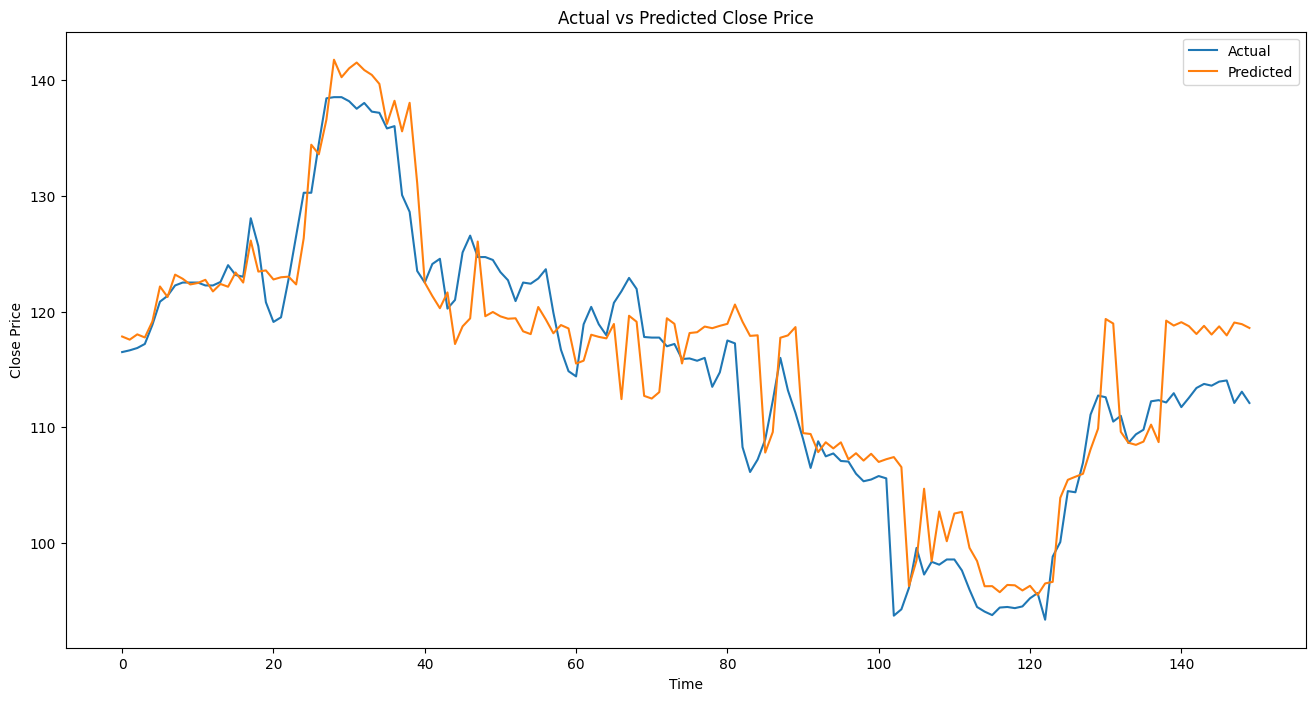

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(df_y_true, label="Actual")
plt.plot(df_y_pred, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Price")
plt.legend()
plt.show()

In [ ]:
cols = list(finaldf.columns)
cols.remove('Close_shifted')
cols.append('Close_shifted')
finaldf = finaldf[cols]
finaldf

,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,0.500277,0.115451,83.5375,87.075,87.660,24.035,84.3625,82.500000
1,0.412106,0.322818,84.2000,90.500,86.610,23.790,82.4000,84.200000
2,0.477317,0.198540,83.4500,88.600,86.790,24.030,84.2500,85.750000
3,0.502541,0.435802,83.7500,85.700,87.040,24.220,85.6500,84.750000
4,0.500139,0.237815,82.7500,83.500,87.340,24.100,85.1500,84.050000
...,...,...,...,...,...,...,...,...
1886,0.467712,0.338347,100.0500,128.900,98.920,30.830,113.9000,113.950000
1887,0.385516,0.421901,98.6000,129.000,98.340,30.730,114.0500,114.050000
1888,0.480284,0.300230,98.8800,129.100,99.360,31.100,114.4400,112.106667
1889,0.432900,0.361066,98.7400,129.050,98.850,30.915,114.2450,113.078333


### NEW LSTM

In [ ]:
# pip install tensorflow

In [ ]:
finaldf.columns

Index(['weightedPolarity', 'weightedSubjectivity', 'richards_bay_futures',
       'newcastle_futures', 'dow_jones', 'bloomberg_index',
       'argus_mccloskey_futures', 'Close_shifted'],
      dtype='object')

In [ ]:
# Assuming your finaldf has shape (n_samples, 8)
X = finaldf.iloc[:, :-1].values  # Input features
y = finaldf.iloc[:, -1].values   # Output

# X = finaldf[['weightedPolarity', 'weightedSubjectivity']]
# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

X_train = X_scaled[:1600]
y_train = y_scaled[:1600]
X_test = X_scaled[-291:]
y_test = y_scaled[-291:]

# Reshape the data for LSTM
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1600, 7), (291, 7), (1600, 1), (291, 1))

In [ ]:
# Define the model
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
# model.add(LSTM(40, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(30))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=500, batch_size=32,verbose = 0)

In [ ]:
# Make predictions
y_pred_scaled = model.predict(X_test_reshaped)

10/10 [==============================] - 1s 3ms/step


In [ ]:
y_pred_scaled.shape

(291, 1)

In [ ]:
# Inverse scale the predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

In [ ]:
y_pred.shape

(291, 1)

In [ ]:
y_pred_df = pd.DataFrame(y_pred)

In [ ]:
y_test.shape

(291, 1)

In [ ]:
y_test_invscaled = scaler_y.inverse_transform(y_test)

In [ ]:
y_test_invs_df = pd.DataFrame(y_test_invscaled)

In [ ]:
results_df = pd.concat([y_pred_df, y_test_invs_df], axis=1)
results_df.columns = ['pred', 'test']


In [ ]:
mae = mean_absolute_error(results_df['test'], results_df['pred'])
print("Mean absolute error:", mae)


Mean absolute error: 5.063342687163293


In [ ]:
dates = df['date'][-291:]

In [ ]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_invscaled, y_pred))
r2 = r2_score(y_test_invscaled, y_pred)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

RMSE: 5.9361615118170254
R-squared: 0.781724310820729


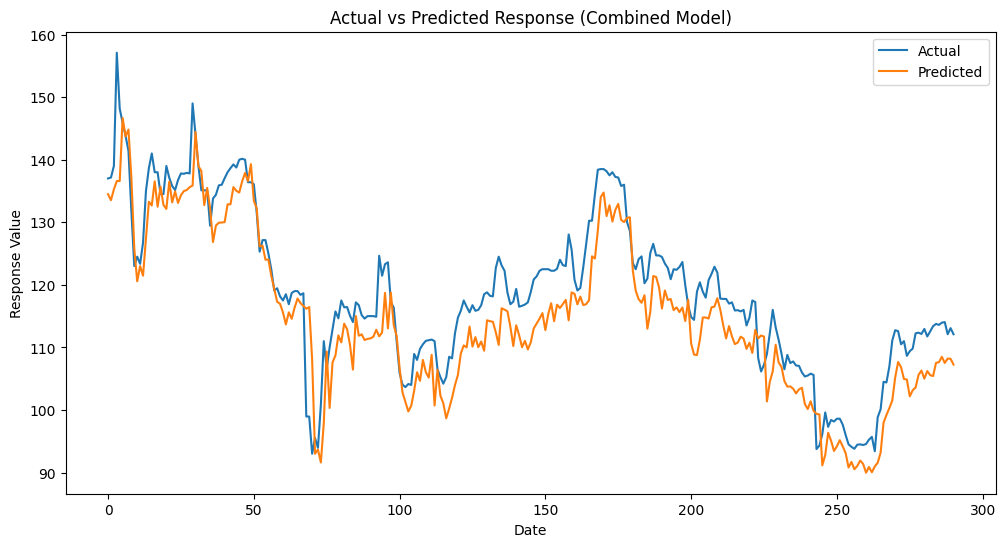

In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs actual
plt.figure(figsize=(12, 6))
plt.plot(results_df['test'], label='Actual')
plt.plot(results_df['pred'], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Response (Combined Model)')
plt.xlabel('Date')
plt.ylabel('Response Value')
plt.show()


In [ ]:
# Calculate the root mean squared error (RMSE) of the training data
rmse_train = np.sqrt(mean_squared_error(finaldf_train_y, regressor.predict(finaldf_train_x)))

# Print the RMSE
print("Root mean squared error (train):", rmse_train)


Root mean squared error (train): 2.9281112733997063


In [ ]:
results_df.head()

In [ ]:
results_df.to_csv('/content/drive/My Drive/RT/lstm_pred_test.csv')

In [ ]:
# Assuming your finaldf has shape (n_samples, 8)
# X = finaldf.iloc[:, :-1].values  # Input features
X = finaldf[['weightedPolarity', 'weightedSubjectivity']]
y = finaldf.iloc[:, -1].values   # Output

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

X_train = X_scaled[:1600]
y_train = y_scaled[:1600]
X_test = X_scaled[-291:]
y_test = y_scaled[-291:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1600, 2), (291, 2), (1600, 1), (291, 1))

In [ ]:
# Define the hyperparameters to iterate over
hidden_layers = [1, 2, 3]
neurons = [20, 30, 40]

# Create a dictionary to store RMSE and R-squared scores
rmse_dict = {}
r2_dict = {}
rmsetrain_dict ={}
r2train_dict = {}

# Create a DataFrame to store predictions
predictions_df = pd.DataFrame(y_test)
pred_on_train_df = pd.DataFrame(y_train)
predictions_df.columns = ['y_test']
pred_on_train_df.columns = ['y_train']

for num_layers in hidden_layers:
    for num_neurons in neurons:
        # Define the model
        model = Sequential()
        model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.2))
        for _ in range(num_layers):
            model.add(LSTM(num_neurons, return_sequences=True))
            model.add(Dropout(0.2))
        model.add(LSTM(num_neurons))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=Adam(), loss='mean_squared_error')

        # Fit the model
        model.fit(X_train, y_train, epochs=500, batch_size=32,verbose = 0)

        # Make predictions
        y_pred_scaled = model.predict(X_test_reshaped)

        # Inverse scale the predictions
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_test_invscaled = scaler_y.inverse_transform(y_test)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_invscaled, y_pred))

        # Calculate R-squared
        r2 = r2_score(y_test_invscaled, y_pred)

        # Store RMSE and R-squared scores in the dictionary
        rmse_dict[f'Layers_{num_layers}_Neurons_{num_neurons}'] = rmse
        r2_dict[f'Layers_{num_layers}_Neurons_{num_neurons}'] = r2

        y_train_scaled = model.predict(X_train_reshaped)
        y_train_p = scaler_y.inverse_transform(y_train_scaled)
        y_train_invscaled= scaler_y.inverse_transform(y_train)

        rmse_train = np.sqrt(mean_squared_error(y_train_invscaled, y_train_p))

        # Calculate R-squared
        r2_train = r2_score(y_train_invscaled, y_train_p)

        rmsetrain_dict[f'Layers_{num_layers}_Neurons_{num_neurons}'] = rmse_train
        r2train_dict[f'Layers_{num_layers}_Neurons_{num_neurons}'] = r2_train

        # Store predictions in the DataFrame
        predictions_df[f'Predictions_Layers_{num_layers}_Neurons_{num_neurons}'] = y_pred
        pred_on_train_df[f'Predictions_Layers_{num_layers}_Neurons_{num_neurons}'] = y_train_p

        print(f'Predictions_Layers_{num_layers}_Neurons_{num_neurons} completed')
# Save predictions DataFrame to a CSV file
predictions_df.to_csv('/content/drive/My Drive/lstm_predictions1.csv', index=False)
pred_on_train_df.to_csv('/content/drive/My Drive/lstm_predictions_on_train1.csv', index=False)

50/50 [==============================] - 0s 3ms/step
Predictions_Layers_1_Neurons_20 completed
50/50 [==============================] - 0s 3ms/step
Predictions_Layers_1_Neurons_30 completed
50/50 [==============================] - 0s 4ms/step
Predictions_Layers_1_Neurons_40 completed
50/50 [==============================] - 0s 4ms/step
Predictions_Layers_2_Neurons_20 completed
50/50 [==============================] - 0s 3ms/step
Predictions_Layers_2_Neurons_30 completed
50/50 [==============================] - 0s 3ms/step
Predictions_Layers_2_Neurons_40 completed
50/50 [==============================] - 0s 4ms/step
Predictions_Layers_3_Neurons_20 completed
50/50 [==============================] - 0s 4ms/step
Predictions_Layers_3_Neurons_30 completed
50/50 [==============================] - 0s 4ms/step
Predictions_Layers_3_Neurons_40 completed


In [ ]:
rmse_dict

{'Layers_1_Neurons_20': 17.35506143817845,
 'Layers_1_Neurons_30': 16.984316041153466,
 'Layers_1_Neurons_40': 17.450229391640114,
 'Layers_2_Neurons_20': 17.047984392220677,
 'Layers_2_Neurons_30': 17.043031475061255,
 'Layers_2_Neurons_40': 17.158059841200107,
 'Layers_3_Neurons_20': 17.36462648623587,
 'Layers_3_Neurons_30': 17.833710355564197,
 'Layers_3_Neurons_40': 18.351584951340588}

In [ ]:
r2_dict

{'Layers_1_Neurons_20': -0.8657191167526428,
 'Layers_1_Neurons_30': -0.7868581428476016,
 'Layers_1_Neurons_40': -0.8862368768597464,
 'Layers_2_Neurons_20': -0.8002798840150565,
 'Layers_2_Neurons_30': -0.7992339724682467,
 'Layers_2_Neurons_40': -0.8236030374375614,
 'Layers_3_Neurons_20': -0.8677762239319009,
 'Layers_3_Neurons_30': -0.970050542021778,
 'Layers_3_Neurons_40': -1.0861287458109579}

In [ ]:
rmsetrain_dict

{'Layers_1_Neurons_20': 86.21725977042459,
 'Layers_1_Neurons_30': 86.17423017813448,
 'Layers_1_Neurons_40': 86.14763722604098,
 'Layers_2_Neurons_20': 86.20135648747754,
 'Layers_2_Neurons_30': 86.17391221381722,
 'Layers_2_Neurons_40': 86.29718490617421,
 'Layers_3_Neurons_20': 86.74379584017957,
 'Layers_3_Neurons_30': 86.28139200777468,
 'Layers_3_Neurons_40': 86.25389612196774}

In [ ]:
r2train_dict

{'Layers_1_Neurons_20': 0.03318494197532007,
 'Layers_1_Neurons_30': 0.03414974360626266,
 'Layers_1_Neurons_40': 0.034745765095296255,
 'Layers_2_Neurons_20': 0.0335415785794565,
 'Layers_2_Neurons_30': 0.034156871151240664,
 'Layers_2_Neurons_40': 0.03139159707673578,
 'Layers_3_Neurons_20': 0.021340041139668253,
 'Layers_3_Neurons_30': 0.03174608684090685,
 'Layers_3_Neurons_40': 0.032363108804545404}

In [ ]:
df

,date,day_x,weightedPolarity,weightedSubjectivity,richards_bay_futures,newcastle_futures,dow_jones,bloomberg_index,argus_mccloskey_futures,Close_shifted
0,2017-01-02,Monday,0.500277,0.115451,83.5375,87.075,87.660,24.035,84.3625,82.500000
1,2017-01-03,Tuesday,0.412106,0.322818,84.2000,90.500,86.610,23.790,82.4000,84.200000
2,2017-01-04,Wednesday,0.477317,0.198540,83.4500,88.600,86.790,24.030,84.2500,85.750000
3,2017-01-05,Thursday,0.502541,0.435802,83.7500,85.700,87.040,24.220,85.6500,84.750000
4,2017-01-06,Friday,0.500139,0.237815,82.7500,83.500,87.340,24.100,85.1500,84.050000
...,...,...,...,...,...,...,...,...,...,...
1886,2024-03-26,Tuesday,0.467712,0.338347,100.0500,128.900,98.920,30.830,113.9000,113.950000
1887,2024-03-27,Wednesday,0.385516,0.421901,98.6000,129.000,98.340,30.730,114.0500,114.050000
1888,2024-03-28,Thursday,0.480284,0.300230,98.8800,129.100,99.360,31.100,114.4400,112.106667
1889,2024-03-29,Friday,0.432900,0.361066,98.7400,129.050,98.850,30.915,114.2450,113.078333


In [ ]:
with open('/content/drive/My Drive/RT/finaldf_6_topics.pkl', 'rb') as f:
  finaldf = pickle.load(f)


In [ ]:
finaldf.to_csv('/content/drive/My Drive/RT/data.csv')